In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! unzip -q '/content/drive/My Drive/Colab Notebooks/train.zip' -d dataset
! unzip -q '/content/drive/My Drive/Colab Notebooks/test.zip' -d dataset

In [3]:
%tensorflow_version 2.x
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import load_model
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [185]:
SIZE = 48
BS = 128

In [186]:
def get_datagen(dataset):
    return ImageDataGenerator().flow_from_directory(
              dataset,
              target_size=(SIZE, SIZE),
              shuffle = True,
              class_mode='categorical',
              batch_size=BS)

In [187]:
from skimage import io, transform

X_test_gen = get_datagen('/content/test')

X_test = np.zeros((len(X_test_gen.filepaths), SIZE, SIZE,3))
Y_test = np.zeros((len(X_test_gen.filepaths), 7))
for i in range(0,len(X_test_gen.filepaths)):
  x = io.imread(X_test_gen.filepaths[i], as_gray=True)
  X_test[i,:] = transform.resize(x, (SIZE, SIZE,3))
  Y_test[i,X_test_gen.classes[i]] = 1

Found 5512 images belonging to 7 classes.


In [188]:
model = load_model('/content/drive/MyDrive/model/Baseline/baseline-EPOCHS_150-DROPOUT_0.3-test_acc_0.675.h5')

In [189]:
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = Y_test.argmax(axis=1)

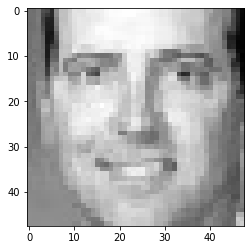

In [247]:
i = 3037
data = X_test[i]
data2 = tf.reduce_sum(data, axis=2)
correct_class = np.argmax(Y_test[i])

# input tensor for model.predict
inp = tf.reshape(data, [1, SIZE, SIZE, 3])
# image data for matplotlib's imshow
img = tf.reshape(data2, [SIZE, SIZE])
# occlusion
img_size = img.shape[0]
occlusion_size = 4
_ = plt.imshow(img,cmap='gray')

In [248]:
def iter_occlusion(image, size=8):
    occlusion = np.full((size * 5, size * 5, 3), [0.5], np.float32)
    occlusion_center = np.full((size, size, 3), [0.5], np.float32)
    occlusion_padding = size * 2

    # print('padding...')
    image_padded = np.pad(image, ( \
                        (occlusion_padding, occlusion_padding), (occlusion_padding, occlusion_padding), (0, 0) \
                        ), 'constant', constant_values = 0.0)

    for y in range(occlusion_padding, image.shape[0] + occlusion_padding, size):
        for x in range(occlusion_padding, image.shape[1] + occlusion_padding, size):
            tmp = image_padded.copy()
            
            # print(tmp.shape,x - occlusion_padding, x + occlusion_center.shape[1] + occlusion_padding,tmp[y - occlusion_padding:y + occlusion_center.shape[0] + occlusion_padding, \
            #     x - occlusion_padding:x + occlusion_center.shape[1] + occlusion_padding].shape, occlusion.shape)
            tmp[y - occlusion_padding:y + occlusion_center.shape[0] + occlusion_padding, \
                x - occlusion_padding:x + occlusion_center.shape[1] + occlusion_padding] \
                = occlusion
            

            tmp[y:y + occlusion_center.shape[0], x:x + occlusion_center.shape[1]] = occlusion_center

            yield x - occlusion_padding, y - occlusion_padding, \
                  tmp[occlusion_padding:tmp.shape[0] - occlusion_padding, occlusion_padding:tmp.shape[1] - occlusion_padding]

In [249]:
print('occluding...')

heatmap = np.zeros((img_size, img_size), np.float32)
class_pixels = np.zeros((img_size, img_size), np.int16)

from collections import defaultdict
counters = defaultdict(int)

for n, (x, y, img_float) in enumerate(iter_occlusion(data, size=occlusion_size)):   
    X = img_float.reshape(1,SIZE, SIZE,3)
    out = model.predict(X)
    print('#{}: {} @ {} (correct class: {})'.format(n, np.argmax(out), np.amax(out), out[0][correct_class]))

    heatmap[y:y + occlusion_size, x:x + occlusion_size] = out[0][correct_class]
    class_pixels[y:y + occlusion_size, x:x + occlusion_size] = np.argmax(out)
    counters[np.argmax(out)] += 1

occluding...
#0: 3 @ 0.9986034035682678 (correct class: 0.9986034035682678)
#1: 3 @ 0.998580813407898 (correct class: 0.998580813407898)
#2: 3 @ 0.9985736608505249 (correct class: 0.9985736608505249)
#3: 3 @ 0.9985688924789429 (correct class: 0.9985688924789429)
#4: 3 @ 0.9985260963439941 (correct class: 0.9985260963439941)
#5: 3 @ 0.998497724533081 (correct class: 0.998497724533081)
#6: 3 @ 0.9985067248344421 (correct class: 0.9985067248344421)
#7: 3 @ 0.9985237717628479 (correct class: 0.9985237717628479)
#8: 3 @ 0.9985474944114685 (correct class: 0.9985474944114685)
#9: 3 @ 0.9985823631286621 (correct class: 0.9985823631286621)
#10: 3 @ 0.99861741065979 (correct class: 0.99861741065979)
#11: 3 @ 0.998612642288208 (correct class: 0.998612642288208)
#12: 3 @ 0.9986065030097961 (correct class: 0.9986065030097961)
#13: 3 @ 0.998578667640686 (correct class: 0.998578667640686)
#14: 3 @ 0.9985600113868713 (correct class: 0.9985600113868713)
#15: 3 @ 0.9985591769218445 (correct class: 0.998

In [250]:
pred = model.predict(inp)
print('Correct class: {}'.format(correct_class))
print('Predicted class: {} (prob: {})'.format(np.argmax(pred), np.amax(out)))

print('Predictions:')
for class_id, count in counters.items():
    print('{}: {}'.format(class_id, count))
    
heatmap=1-heatmap

Correct class: 3
Predicted class: 3 (prob: 0.9986294507980347)
Predictions:
3: 144


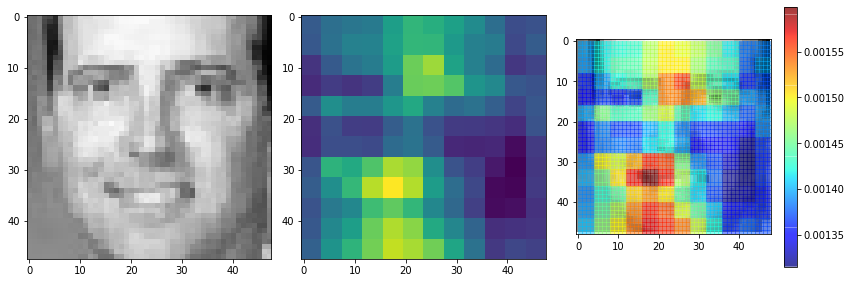

In [251]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import BoundaryNorm
from matplotlib.colorbar import ColorbarBase
from matplotlib import cm
import cv2

fig = plt.figure(figsize=(12,4))

ax1 = plt.subplot(1, 3, 1, aspect='equal')
image = ax1.imshow(data)
ax2 = plt.subplot(1, 3, 2, aspect='equal')
hm = ax2.imshow(heatmap)
ax3 = plt.subplot(1, 3, 3, aspect='equal')
sp = ax3.imshow(img, cmap=cm.gray)
psp = ax3.pcolormesh(heatmap, cmap=plt.cm.jet, alpha=0.50)
fig.colorbar(psp, ax=ax3)
fig.tight_layout()
plt.show()